In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader_02 import PuljaDataLoader
from models._20220727_00 import UserModel
from models.utils_02 import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 1000

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c1, dataset.num_c2, dataset.num_c3, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
model.load_state_dict(
    torch.load(
        os.path.join(
            os.path.join(
                ckpt_path, "_20220727_00"
            ),
            "model_fin.ckpt"
        ),
        map_location=device
    )
)
model.eval()

UserModel(
  (D): Embedding(7, 1)
  (R): Embedding(2, 20)
  (gru): GRU(40, 20, batch_first=True)
  (linear_1): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=60, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
)

In [4]:
aucs_list = []
max_aucs = []
fin_aucs = []

dir_list = ["01"]

for i in dir_list:
    with open(
        os.path.join(
            os.path.join(
                ckpt_path,
                os.path.join("_20220727_00", i)
            ),
            "aucs.pkl"
        ),
        "rb"
    ) as f:
        aucs = pickle.load(f)
    
    max_auc = np.max(aucs)
    fin_auc = aucs[-1]

    aucs_list.append(aucs)
    max_aucs.append(max_auc)
    fin_aucs.append(fin_auc)

In [5]:
print("max_aucs: {}".format(max_aucs))
print("max_auc_mean: {}, max_auc_std: {}".format(np.mean(max_aucs), np.std(max_aucs)))
print("max_auc_dir: {}".format(dir_list[np.argmax(max_aucs)]))

max_aucs: [0.7741200761753892]
max_auc_mean: 0.7741200761753892, max_auc_std: 0.0
max_auc_dir: 01


In [6]:
print("max_fin_aucs: {}".format(fin_aucs))
print("max_fin_auc_mean: {}, max_auc_std: {}".format(np.mean(fin_aucs), np.std(fin_aucs)))
print("max_fin_auc_dir: {}".format(dir_list[np.argmax(fin_aucs)]))

max_fin_aucs: [0.7734779184490739]
max_fin_auc_mean: 0.7734779184490739, max_auc_std: 0.0
max_fin_auc_dir: 01


In [7]:
test_dataset[3]

(array([29, 29, 29, ..., 76, 76, 76]),
 array([2, 2, 3, ..., 4, 4, 4]),
 array([1, 1, 0, ..., 0, 0, 0]))

In [28]:
# 3, 6
c3_seq, d_seq, r_seq = test_dataset[3]

view_from = 100
view_to = 200

seq_len = view_to - view_from

c3_seq = [c3_seq[view_from:view_to]]
d_seq = [d_seq[view_from:view_to]]
r_seq = [r_seq[view_from:view_to]]

# r_seq = np.zeros_like(r_seq)
# r_seq = np.ones_like(r_seq)

# d_seq = np.ones_like(d_seq) * 6

# c_seq = np.array([[0] * 100])
# d_seq = np.array([[6] * 30 + [3] * 30 + [0] * 40])
# r_seq = np.ones_like(r_seq)

# c1_seq, c2_seq, c4_seq, d_seq, r_seq: [batch_size, seq_len]

alpha_seq, h_seq, C3_seq = model(
    LongTensor(c3_seq),
    LongTensor(d_seq),
    LongTensor(r_seq),
)

# C3_seq: [batch_size, seq_len, num_c4]

# beta3_seq: [batch_size, seq_len]
beta3_seq = torch.gather(C3_seq, dim=-1, index=LongTensor(c3_seq).unsqueeze(-1)).reshape([1, seq_len])

# gamma_seq: [seq_len]
gamma_seq = model.D(LongTensor(d_seq)).squeeze()

###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()[0]

sigmoid_alpha_beta_seq = torch.sigmoid(alpha_seq + beta3_seq).detach().cpu().numpy()[0]

sigmoid_alpha_beta_gamma_seq = torch.sigmoid(alpha_seq + beta3_seq - gamma_seq).detach().cpu().numpy()[0]

r_seq_ma = np.cumsum(r_seq[0]) / np.arange(1, r_seq[0].shape[0] + 1)

CQ3_seq = alpha_seq.unsqueeze(-1) + C3_seq.squeeze()
CQ3_seq = torch.sigmoid(CQ3_seq).detach().cpu().numpy()[0]

# C3_seq = C3_seq.squeeze().detach().cpu().numpy()

# alpha_seq = alpha_seq.detach().cpu().numpy()

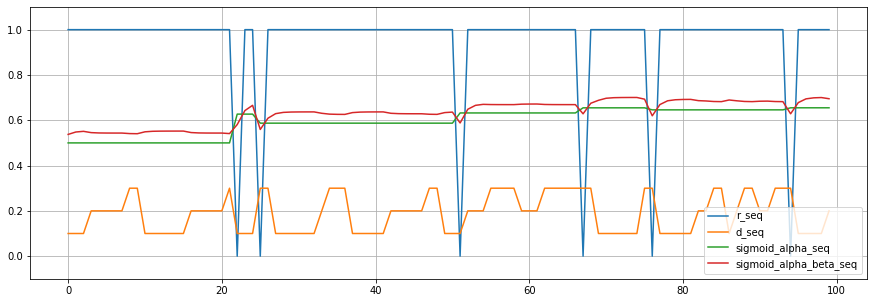

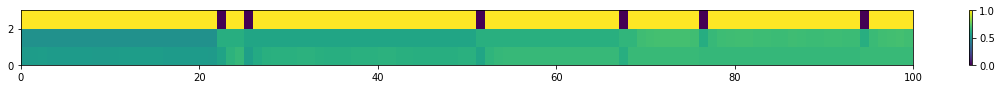

In [31]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
plt.plot(sigmoid_alpha_beta_seq, label="sigmoid_alpha_beta_seq")
# plt.plot(sigmoid_alpha_beta4_seq, label="sigmoid_alpha_beta4_seq")
# plt.plot(sigmoid_beta4_seq, label="sigmoid_beta4_seq")
plt.grid()
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

plt.figure(figsize=[20, len(np.unique(c3_seq)) // 3 + 1], facecolor="white")
temp = np.concatenate([CQ3_seq[:, np.unique(c3_seq)].T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

In [10]:
CQ3_seq[0][np.unique(c3_seq)]

array([0.5       , 0.5       , 0.52999175, 0.5       , 0.5       ,
       0.5       ], dtype=float32)

In [11]:
CQ3_seq[-1][np.unique(c3_seq)]

array([0.57635075, 0.578909  , 0.5778559 , 0.5422641 , 0.5455228 ,
       0.54608214], dtype=float32)

In [12]:
np.unique(c3_seq), c3_seq

(array([17, 26, 29, 50, 73, 75]),
 [array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 50, 50, 50, 50, 50,
         50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 73, 73, 73, 73, 73, 73,
         73, 73, 73, 73, 73, 73, 73, 73, 75, 75, 75, 75, 75, 75, 75, 75, 75,
         75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75,
         75, 75, 75, 75, 75, 75, 75, 75, 75, 17, 17, 17, 17, 17, 17, 17, 17,
         17, 17, 17, 17, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26])])

In [13]:
dataset.c3_list[np.unique(c3_seq)]

array(['01 유리식', '01 집합의 뜻과 표현', '01 함수', '02 여러 가지 함수', '03 합성함수',
       '04 역함수'], dtype=object)

In [14]:
dataset.c3_list[np.unique(c3_seq)[np.argmin(CQ3_seq[-1][np.unique(c3_seq)])]]

'02 여러 가지 함수'

In [15]:
dataset.c32c4_list[dataset.c3_list[np.unique(c3_seq)[np.argmin(CQ3_seq[-1][np.unique(c3_seq)])]]]

['[6] 일대일대응', '[7] 일대일대응이 되기 위한 조건', '[8] 항등함수와 상수함수', '[9] 함수의 개수']

In [16]:
d_seq

[array([2, 2, 3, 3, 3, 3, 4, 2, 2, 4, 4, 3, 2, 4, 2, 2, 3, 2, 3, 4, 3, 3,
        3, 3, 3, 3, 2, 4, 3, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3, 4, 2, 3,
        2, 3, 2, 3, 4, 4, 4, 3, 2, 2, 3, 2, 2, 3, 2, 3, 4, 4, 2, 3, 3, 3,
        4, 2, 3, 4, 4, 3, 3, 3, 3, 3, 4, 2, 3, 4, 2, 3, 4, 4, 2, 3, 2, 3,
        3, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0])]

In [17]:
model.D.weight

Parameter containing:
tensor([[-0.9377],
        [-0.6304],
        [-0.2901],
        [ 0.2823],
        [ 0.7041],
        [ 0.9764],
        [ 1.8763]], requires_grad=True)

In [18]:
model.init_alpha

tensor([0])